Notes:

1. Import data into colab in different ways: 
https://medium.com/@snaily16/import-data-into-google-colaboratory-fe80b82e9306

2. np.expand_dims, numpy.expand_dims(a, axis)
Expand the shape of an array. Insert a new axis that will appear at the axis position in the expanded array shape.: https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html

3. Neural style transfer with eager execution: 
https://colab.research.google.com/github/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb#scrollTo=aDyGj8DmXCJI

4. CNN coloring greyscale pictures: https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/

5. flow_from_directory(): https://keras.io/preprocessing/image/
6. binary flow_from_directory example: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
7. Colorization autoencoder: https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/colorization-autoencoder-cifar10-3.4.1.py
8. AE and resnet: https://www.kaggle.com/valkling/image-colorization-using-autoencoders-and-resnet
9. https://medium.com/@mahmoudeljiddawi/auto-colorization-of-black-and-white-images-using-machine-learning-auto-encoders-technique-a213b47f7339

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import numpy as np
import random
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.0.0


In [0]:
os.chdir('/content/drive/My Drive/Final Project (Deep Learning - Fall 2019)')
os.getcwd()

'/content/drive/My Drive/Final Project (Deep Learning - Fall 2019)'

In [0]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, UpSampling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from skimage.transform import resize

In [0]:
# print contents in current directory
"""
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

"\nfor dirname, _, filenames in os.walk('.'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [0]:
# seed for randoom number generator
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
seed_everything(6000)

# Analyze one Image

In [0]:
img = img_to_array(load_img('./DATA/Nature/train/merry0066.tif'))
img = img * 1.0/255
img = np.expand_dims(img, axis=0)
print('Image Shape:', img.shape, 'with pixels in range', np.min(img), 'to', np.max(img))

Image Shape: (1, 576, 768, 3) with pixels in range 0.0 to 1.0


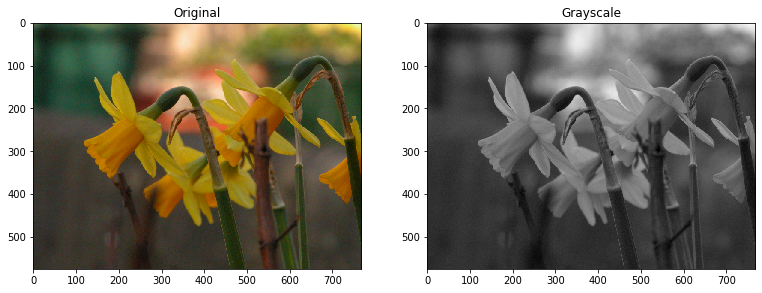

In [0]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 3, 1)
plt.imshow(img[0])
plt.title('Original')
plt.subplot(2, 3, 2)
plt.imshow(rgb2gray(img)[0], cmap='gray')
plt.title('Grayscale')
plt.show()

# Data Processing Functions

In [0]:
def getImageArray(FOLDER_PATH, target_size, isColor):
	image_files_lst = os.listdir(FOLDER_PATH)
	image_files_lst.sort()
	num_images = len(image_files_lst)
	x = []
	if isColor == True:
		color_mode = 'rgb'
	else:
		color_mode = 'grayscale'
	for img in image_files_lst:
		img_arr = img_to_array(load_img(path=FOLDER_PATH + '/' + img, target_size=target_size, color_mode=color_mode)) * 1.0/255
		x.append(img_arr)
	x = np.array(x)
	print('Finished converting', str(num_images), 'images as numpy arrays!')
	return x

def getLabBatch(batch):
	lab_batch = rgb2lab(batch)
	X_batch = lab_batch[:,:,:,0]
	Y_batch = lab_batch[:,:,:,1:] / 128
	return (X_batch.reshape(X_batch.shape+(1,)), Y_batch)
 
def getColorBatch(batch):
	X_batch = rgb2gray(batch)
	Y_batch = batch
	return (X_batch.reshape(X_batch.shape+(1,)), Y_batch)
 
def getTrainValBatch(generator, isLab):
	for batch in generator:
		if isLab == True:
			yield getLabBatch(batch)
		else:
			yield getColorBatch(batch)

# Model Functions

In [0]:
def AE(input_shape, num_filters, kernel_size, num_strides, num_layers, activation, kernel_initializer, kernel_regularizer, addBN, latent_dim, optimizer, loss, model_name):
    in_layer = Input(shape=input_shape)
    x = in_layer
    # encoder
    for i in [2**j for j in range(num_layers)]:
        x = Conv2D(filters=num_filters * i, kernel_size=kernel_size, kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer, padding='same', strides=num_strides, name='encoder_' + str(num_filters * i))(x)
        x = Activation(activation, name='encoder_act_' + str(num_filters * i))(x)
        if addBN == True:
            x = BatchNormalization(name='encoder_BN_' + str(num_filters * i))(x)
    encoder_shape = K.int_shape(x)
	# latent
    x = Flatten(name='latent_flatten')(x)
    x = Dense(latent_dim, name='latent_vector')(x)
	# decoder
    x = Dense(encoder_shape[1] * encoder_shape[2] * encoder_shape[3], name='decoder_dense')(x)
    x = Reshape((encoder_shape[1], encoder_shape[2], encoder_shape[3]), name='decoder_reshape')(x)
    for i in [2**j for j in range(num_layers - 1, -1, -1)]:
        x = Conv2DTranspose(filters=num_filters * i, kernel_size=kernel_size, kernel_initializer=kernel_initializer,
                            kernel_regularizer=kernel_regularizer, padding='same', strides=num_strides, name='decoder_' + str(num_filters * i))(x)
        x = Activation(activation, name='decoder_act_' + str(num_filters * i))(x)
        #x = UpSampling2D((2,2))(x)
        if addBN == True:
            x = BatchNormalization(name='decoder_BN_' + str(num_filters * i))(x)
    out_layer = Conv2D(filters=3, kernel_size=kernel_size, activation='sigmoid', padding='same', strides=1)(x)
    model = Model(in_layer, out_layer, name=model_name + '_AE')
    model.summary()
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [0]:
print([2**i for i in range(4,-1,-1)])

[16, 8, 4, 2, 1]


# Evaluation Functions

In [0]:
def image_colorfulness(image):
    image = np.flip(image, axis=2) # convert RGB to BGR
    (B, G, R) = cv2.split(image) # split the image into its respective RGB components
    rg = np.absolute(R - G) # compute rg = R - G
    yb = np.absolute(0.5 * (R + G) - B) # compute yb = 0.5 * (R + G) - B
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

# Prepare Data for Training

In [0]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [0]:
# specify image data generators
train_datagen = ImageDataGenerator(data_format='channels_last', rescale=1./255, validation_split=0.131, 
                                   shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(directory='./DATA', subset='training', classes=['Flower-17'], 
                                                    class_mode=None, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow_from_directory(directory='./DATA', subset='validation', classes=['Flower-17'], 
                                                  class_mode=None, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)

Found 1182 images belonging to 1 classes.
Found 178 images belonging to 1 classes.


In [0]:
# check size/scale for train and val images
x = train_generator[0]
print('Shape of TRAIN Batch:', x[0].shape, 'with images in range', x[0].min(), 'to', x[0].max())
x = val_generator[0]
print('Shape of VAL Batch:', x[0].shape, 'with images in range', x[0].min(), 'to', x[0].max())

Shape of TRAIN Batch: (224, 224, 3) with images in range 0.0 to 1.0
Shape of VAL Batch: (224, 224, 3) with images in range 0.0 to 1.0


In [0]:
"""
train_color=getImageArray(FOLDER_PATH='./DATA/Nature/train', target_size=TARGET_SIZE, isColor=True)
train_X, train_Y = getColorBatch(train_color)
test_color = getImageArray(FOLDER_PATH='./DATA/Nature/test', target_size=TARGET_SIZE, isColor=True)
test_X, test_Y = getColorBatch(test_color)
"""

Finished converting 230 images as numpy arrays!


In [0]:
# load test data as numpy
test_color = getImageArray(FOLDER_PATH='./DATA/Nature/test', target_size=TARGET_SIZE, isColor=True)
test_gray = rgb2gray(test_color)
test_gray = test_gray.reshape(test_gray.shape+(1,))
print('Shape of TEST COLOR:', test_color.shape, 'with images in range', test_color.min(), 'to', test_color.max())
print('Shape of TEST GRAY:', test_gray.shape, 'with images in range', test_gray.min(), 'to', test_gray.max())

Finished converting 28 images as numpy arrays!
Shape of TEST COLOR: (28, 224, 224, 3) with images in range 0.0 to 1.0
Shape of TEST GRAY: (28, 224, 224, 1) with images in range 0.0 to 0.99999994


# Reva's AE Model

In [0]:
ae_l2 = AE(input_shape=TARGET_SIZE+(1,), num_filters=32, kernel_size=(3, 3), num_strides=2, 
           num_layers=4, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=None, 
           addBN=False, latent_dim=512, optimizer='adam', loss='mse', model_name='baseline-L2')

Model: "baseline-L2_AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
encoder_32 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
encoder_act_32 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_64 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
encoder_act_64 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_128 (Conv2D)         (None, 16, 16, 128)       73856     
_________________________________________________________________
encoder_act_128 (Activation) (None, 16, 16, 128)    

In [0]:
# fit model
start = time.time()
history_baseline = ae_l2.fit_generator(getTrainValBatch(generator=train_generator, isLab=False), 
                                       epochs=500, steps_per_epoch=len(train_generator), verbose=1,
                                       validation_data=getTrainValBatch(generator=val_generator, isLab=False), 
                                       validation_steps=len(val_generator), use_multiprocessing=True)
end = time.time() - start
print('\n\t\t\tTotal Training Time:', np.round(end, 2), 'seconds')

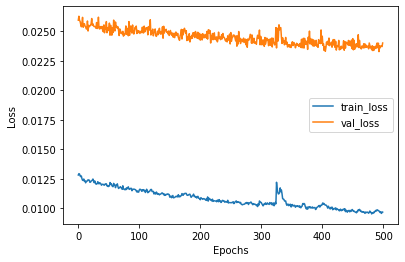

In [0]:
# plot history
plt.plot(history_baseline.history['loss'], label='train_loss')
plt.plot(history_baseline.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [0]:
# evaluate test performance and make predictions
test_X, test_Y = getColorBatch(test_color)
print('Shape of test_X:', test_X.shape, ' test_Y:', test_Y.shape)
print('Test Performance:', ae_l2.evaluate(test_X, test_Y, verbose=0))
test_pred = ae_l2.predict(test_X)
print('Shape of test predictions:', test_pred.shape)

Shape of test_X: (28, 128, 128, 1)  test_Y: (28, 128, 128, 3)
Test Performance: 0.023668378591537476
Shape of test predictions: (28, 128, 128, 3)


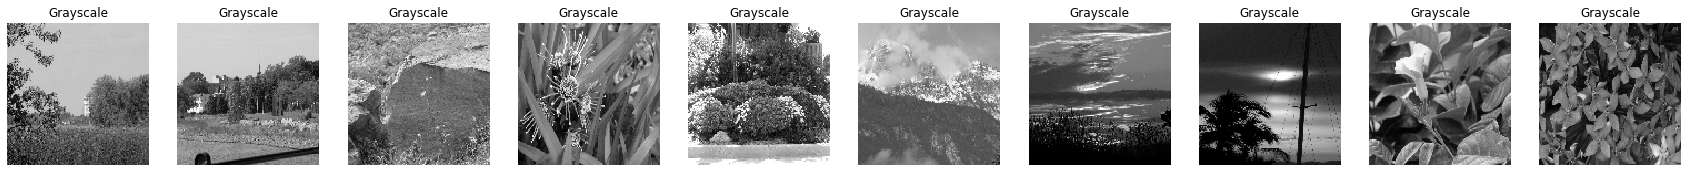

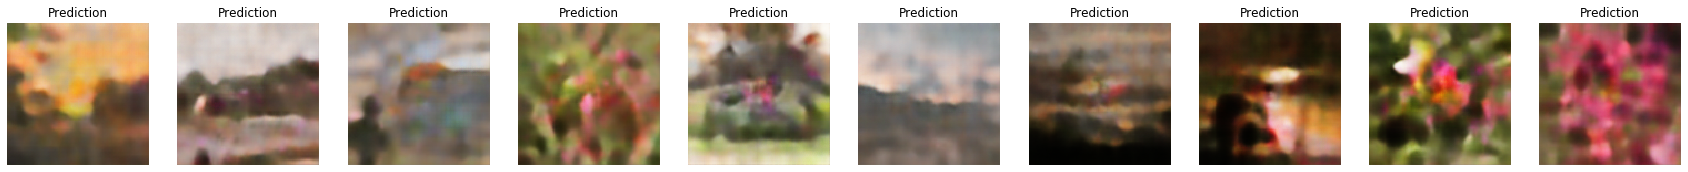

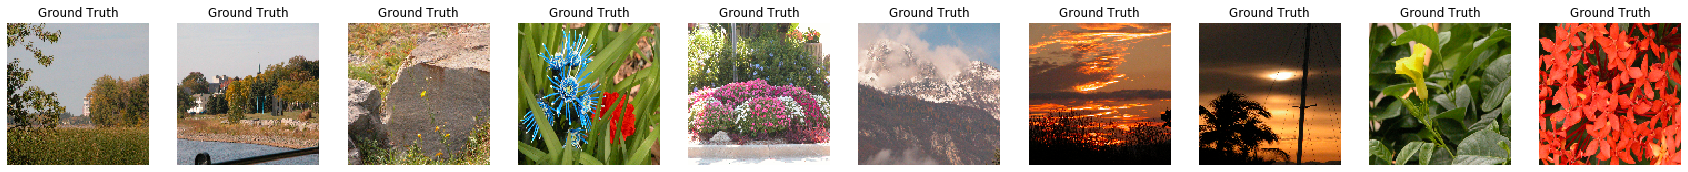

In [0]:
# visualize test output
plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(rgb2gray(test_Y[i]), cmap='gray')
    plt.axis('off')
    plt.title('Grayscale')
plt.show()

plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_pred[i])
    plt.axis('off')
    plt.title('Prediction')
plt.show()

plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_Y[i])
    plt.axis('off')
    plt.title('Ground Truth')
plt.show()

#My AE Model

In [0]:
# network parameters
input_shape = (224, 224, 1)
batch_size = 32
kernel_size = 3
#latent_dim=1024
#latent_dim = 1024
latent_dim=512
channels=3
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64,128,256,512]



# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 512)       1180160   
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
latent_vector (Dense)        (None, 512)               5138

In [0]:
"""
TARGET_SIZE=(128,128)
train_color=getImageArray(FOLDER_PATH='./DATA/Nature/train', target_size=TARGET_SIZE, isColor=True)
#train_X, train_Y = getColorBatch(train_color)
test_color = getImageArray(FOLDER_PATH='./DATA/Nature/test', target_size=TARGET_SIZE, isColor=True)
#test_X, test_Y = getColorBatch(test_color)
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray_(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
train_grey=rgb2gray_(train_color).reshape(-1,128,128,1)
test_grey=rgb2gray_(test_color).reshape(-1,128,128,1)
"""

Finished converting 230 images as numpy arrays!
Finished converting 28 images as numpy arrays!


In [0]:
train_grey.shape

(230, 128, 128, 1)

In [0]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [0]:
# fit model

start = time.time()
history_baseline = autoencoder.fit_generator(getTrainValBatch(generator=train_generator, isLab=False), 
                                       epochs=500, steps_per_epoch=len(train_generator), verbose=1,
                                       validation_data=getTrainValBatch(generator=val_generator, isLab=False), 
                                       validation_steps=len(val_generator), use_multiprocessing=True,callbacks=[checkpoint,lr_reducer])
end = time.time() - start
print('\n\t\t\tTotal Training Time:', np.round(end, 2), 'seconds')

"""
# called every epoch
callbacks = [lr_reducer, checkpoint]
# train the autoencoder
#validation_data=(test_X, test_Y)
#train_X_=train_X[:180]
#train_X_val=train_X[180:]
#train_Y_=train_Y[:180]
#train_Y_val=train_Y[180:]

history_baseline=autoencoder.fit(train_grey,
                train_color,validation_data=(test_grey, test_color),
                epochs=100,
                batch_size=batch_size,
                callbacks=callbacks)
"""

Epoch 1/500
36/37 [============================>.] - ETA: 9s - loss: 0.0720 
Epoch 00001: val_loss improved from inf to 0.05853, saving model to /content/drive/My Drive/Final Project (Deep Learning - Fall 2019)/saved_models/colorized_ae_model.001.h5
37/37 [==============================] - 406s 11s/step - loss: 0.0716 - val_loss: 0.0585
Epoch 2/500
36/37 [============================>.] - ETA: 0s - loss: 0.0513
Epoch 00002: val_loss improved from 0.05853 to 0.04767, saving model to /content/drive/My Drive/Final Project (Deep Learning - Fall 2019)/saved_models/colorized_ae_model.002.h5
37/37 [==============================] - 35s 949ms/step - loss: 0.0511 - val_loss: 0.0477
Epoch 3/500
36/37 [============================>.] - ETA: 0s - loss: 0.0445
Epoch 00003: val_loss improved from 0.04767 to 0.04212, saving model to /content/drive/My Drive/Final Project (Deep Learning - Fall 2019)/saved_models/colorized_ae_model.003.h5
37/37 [==============================] - 34s 924ms/step - loss: 0

Shape of test_X: (28, 128, 128, 1)  test_Y: (28, 128, 128, 3)
Test Performance: 0.023641902953386307
Shape of test predictions: (28, 128, 128, 3)


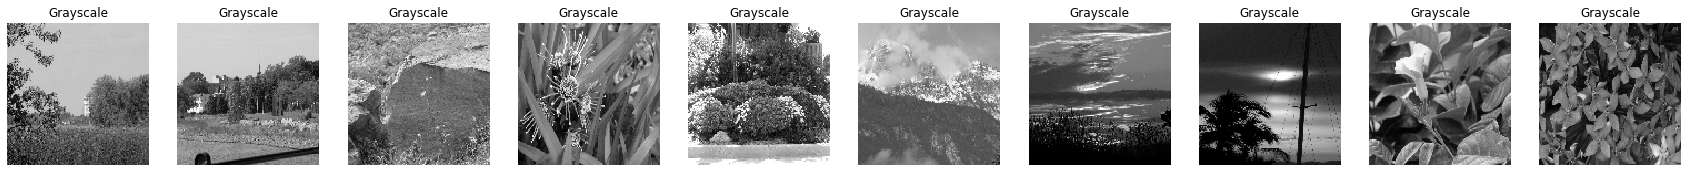

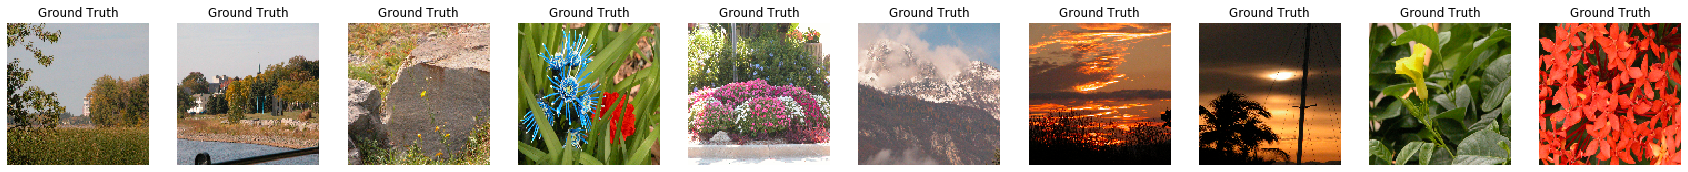

In [0]:
# plot history
plt.plot(history_baseline.history['loss'], label='train_loss')
plt.plot(history_baseline.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# evaluate test performance and make predictions
test_X, test_Y = getColorBatch(test_color)
print('Shape of test_X:', test_X.shape, ' test_Y:', test_Y.shape)
print('Test Performance:', autoencoder.evaluate(test_X, test_Y, verbose=0))
#autoencoder pred

test_pred = autoencoder.predict(test_X)
#test_pred = autoencoder.predict(test_grey)

print('Shape of test predictions:', test_pred.shape)

# visualize test output
plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(rgb2gray(test_Y[i]), cmap='gray')
    #plt.imshow(rgb2gray(test_color[i]))
    plt.axis('off')
    plt.title('Grayscale')
plt.show()

plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_pred[i])
    plt.axis('off')
    plt.title('Prediction')
plt.show()

plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_Y[i])
    plt.axis('off')
    plt.title('Ground Truth')
plt.show()

KeyError: ignored

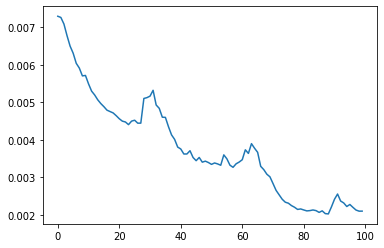

In [0]:
# plot history
plt.plot(history_baseline.history['loss'], label='train_loss')
plt.plot(history_baseline.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# evaluate test performance and make predictions
test_X, test_Y = getColorBatch(test_color)
print('Shape of test_X:', test_X.shape, ' test_Y:', test_Y.shape)
print('Test Performance:', autoencoder.evaluate(test_X, test_Y, verbose=0))
#autoencoder pred
test_pred = autoencoder.predict(test_X)
print('Shape of test predictions:', test_pred.shape)

# visualize test output
plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(rgb2gray(test_Y[i]), cmap='gray')
    plt.axis('off')
    plt.title('Grayscale')
plt.show()

plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_pred[i])
    plt.axis('off')
    plt.title('Prediction')
plt.show()

plt.figure(figsize=(30, 30))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_Y[i])
    plt.axis('off')
    plt.title('Ground Truth')
plt.show()